In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import statistics as st

def get_df(day):
    file_name = f"./round_3_data/prices_round_3_day_{day}.csv"
    return pd.read_csv(file_name, sep=';')

def get_product(df, product):
    return df[df['product'] == product].copy()

def get_first_two_dfs():
    zero_df = get_df(0)
    first_df = get_df(1)
    second_df = get_df(2)
    first_df['timestamp'] = first_df['timestamp'] + 1000000
    second_df['timestamp'] = second_df['timestamp'] + 2000000
    return pd.concat([zero_df, first_df, second_df])



In [2]:
df = get_first_two_dfs()

In [3]:

df_coconut = get_product(df, 'VOLCANIC_ROCK')
df_coconut_call = get_product(df, "VOLCANIC_ROCK_VOUCHER_10500")
df_coconut_call = df_coconut_call.merge(df_coconut[['timestamp', 'mid_price']], on='timestamp', suffixes=('', '_coconut'))

In [4]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_coconut['timestamp'], y=df_coconut['mid_price'], name='Coconut Mid Price'))
fig.add_trace(go.Scatter(x=df_coconut_call['timestamp'], y=df_coconut_call['mid_price'], name='Coconut Call Mid Price', yaxis='y2'))
fig.update_layout(title='Coconut and Coconut Call Prices over Timestamp', yaxis=dict(title='Coconut Mid Price'), yaxis2=dict(title='Coconut Call Bid Price', overlaying='y', side='right'))
fig.show()


In [12]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq

def black_scholes_call(spot, strike, time_to_expiry, volatility):
    d1 = (np.log(spot / strike) + (0.5 * volatility ** 2) * time_to_expiry) / (volatility * np.sqrt(time_to_expiry))
    d2 = d1 - volatility * np.sqrt(time_to_expiry)
    call_price = (spot * norm.cdf(d1) - strike * norm.cdf(d2))
    return call_price

def black_scholes_put(spot, strike, time_to_expiry, volatility):
    d1 = (np.log(spot / strike) + (0.5 * volatility ** 2) * time_to_expiry) / (volatility * np.sqrt(time_to_expiry))
    d2 = d1 - volatility * np.sqrt(time_to_expiry)
    put_price = (strike * norm.cdf(-d2) - spot * norm.cdf(-d1))
    return put_price

def delta(spot, strike, time_to_expiry, volatility):
    d1 = (np.log(spot) - np.log(strike) + (0.5 * volatility ** 2) * time_to_expiry) / (volatility * np.sqrt(time_to_expiry))
    return norm.cdf(d1)

def gamma(spot, strike, time_to_expiry, volatility):
    d1 = (np.log(spot) - np.log(strike) + (0.5 * volatility ** 2) * time_to_expiry) / (volatility * np.sqrt(time_to_expiry))
    return norm.pdf(d1)/(spot * volatility * np.sqrt(time_to_expiry))

def vega(spot, strike, time_to_expiry, volatility):
    d1 = (np.log(spot) - np.log(strike) + (0.5 * volatility ** 2) * time_to_expiry) / (volatility * np.sqrt(time_to_expiry))
    return norm.pdf(d1) * (spot * np.sqrt(time_to_expiry)) / 100

def implied_volatility(call_price, spot, strike, time_to_expiry):
    from scipy.optimize import root_scalar
    # Define the equation where the root is the implied volatility
    def equation(volatility):
        estimated_price = black_scholes_call(spot, strike, time_to_expiry, volatility)
        return estimated_price - call_price

    # Using Brent's method to find the root of the equation
    # result = root_scalar(equation, bracket=[1e-10, 100.0], method='bisect')
    # implied_vol = result.root
    implied_vol = brentq(equation, 1e-10, 3.0, xtol=1e-10)
    return implied_vol

def realized_vol(df_coconut_call, window, step_size):
    df_coconut_call[f'log_return_{step_size}'] = np.log(df_coconut_call['mid_price_coconut'].to_numpy()/df_coconut_call['mid_price_coconut'].shift(step_size).to_numpy())
    dt = step_size / 250 / 10000 
    df_coconut_call[f'realized_vol_{step_size}'] = df_coconut_call[f'log_return_{step_size}'].rolling(window=window).apply(lambda x: np.mean(x[::step_size]**2) / dt)
    df_coconut_call[f'realized_vol_{step_size}'] = np.sqrt(df_coconut_call[f'realized_vol_{step_size}'].to_numpy())
    return df_coconut_call



In [46]:
spot_price = 10000        # Spot price of the underlying asset
strike_price = 10500      # Strike price of the option
call_price = 637.5         # Market price of the call option
time_to_expiry = 4/252      # Time to expiry in years
initial_guess = 16
df_coconut_call['implied_vol'] = df_coconut_call.apply(lambda row: implied_volatility(row['mid_price'], row['mid_price_coconut'], strike_price, time_to_expiry), axis=1)
# df_coconut_call['delta'] = df_coconut_call.apply(lambda row: delta(row['mid_price_coconut'], strike_price, time_to_expiry, row['implied_vol']), axis=1)
# df_coconut_call['gamma'] = df_coconut_call.apply(lambda row: gamma(row['mid_price_coconut'], strike_price, time_to_expiry, row['implied_vol']), axis=1)
# df_coconut_call['vega'] = df_coconut_call.apply(lambda row: vega(row['mid_price_coconut'], strike_price, time_to_expiry, row['implied_vol']), axis=1)

In [13]:
df = get_first_two_dfs()
df_coconut_call = get_product(df, "VOLCANIC_ROCK_VOUCHER_10500")
df_coconut_call = df_coconut_call.merge(df_coconut[['timestamp', 'mid_price']], on='timestamp', suffixes=('', '_coconut'))
for product in ["VOLCANIC_ROCK_VOUCHER_10000", "VOLCANIC_ROCK_VOUCHER_10250", "VOLCANIC_ROCK_VOUCHER_10500"]:
    temp = get_product(df, product)
    df_coconut_call = df_coconut_call.merge(temp[['timestamp', 'mid_price']], on='timestamp', suffixes=('', f'_{product}'))
    strike_price = float(product.split('_')[-1])
    time_to_expiry = float(4/252)
    df_coconut_call[f'implied_vol_{product}'] = df_coconut_call.apply(lambda row: implied_volatility(row[f'mid_price_{product}'], row['mid_price_coconut'], strike_price, time_to_expiry), axis=1)
print(df_coconut_call.columns)

Index(['day', 'timestamp', 'product', 'bid_price_1', 'bid_volume_1',
       'bid_price_2', 'bid_volume_2', 'bid_price_3', 'bid_volume_3',
       'ask_price_1', 'ask_volume_1', 'ask_price_2', 'ask_volume_2',
       'ask_price_3', 'ask_volume_3', 'mid_price', 'profit_and_loss',
       'mid_price_coconut', 'mid_price_VOLCANIC_ROCK_VOUCHER_10000',
       'implied_vol_VOLCANIC_ROCK_VOUCHER_10000',
       'mid_price_VOLCANIC_ROCK_VOUCHER_10250',
       'implied_vol_VOLCANIC_ROCK_VOUCHER_10250',
       'mid_price_VOLCANIC_ROCK_VOUCHER_10500',
       'implied_vol_VOLCANIC_ROCK_VOUCHER_10500'],
      dtype='object')


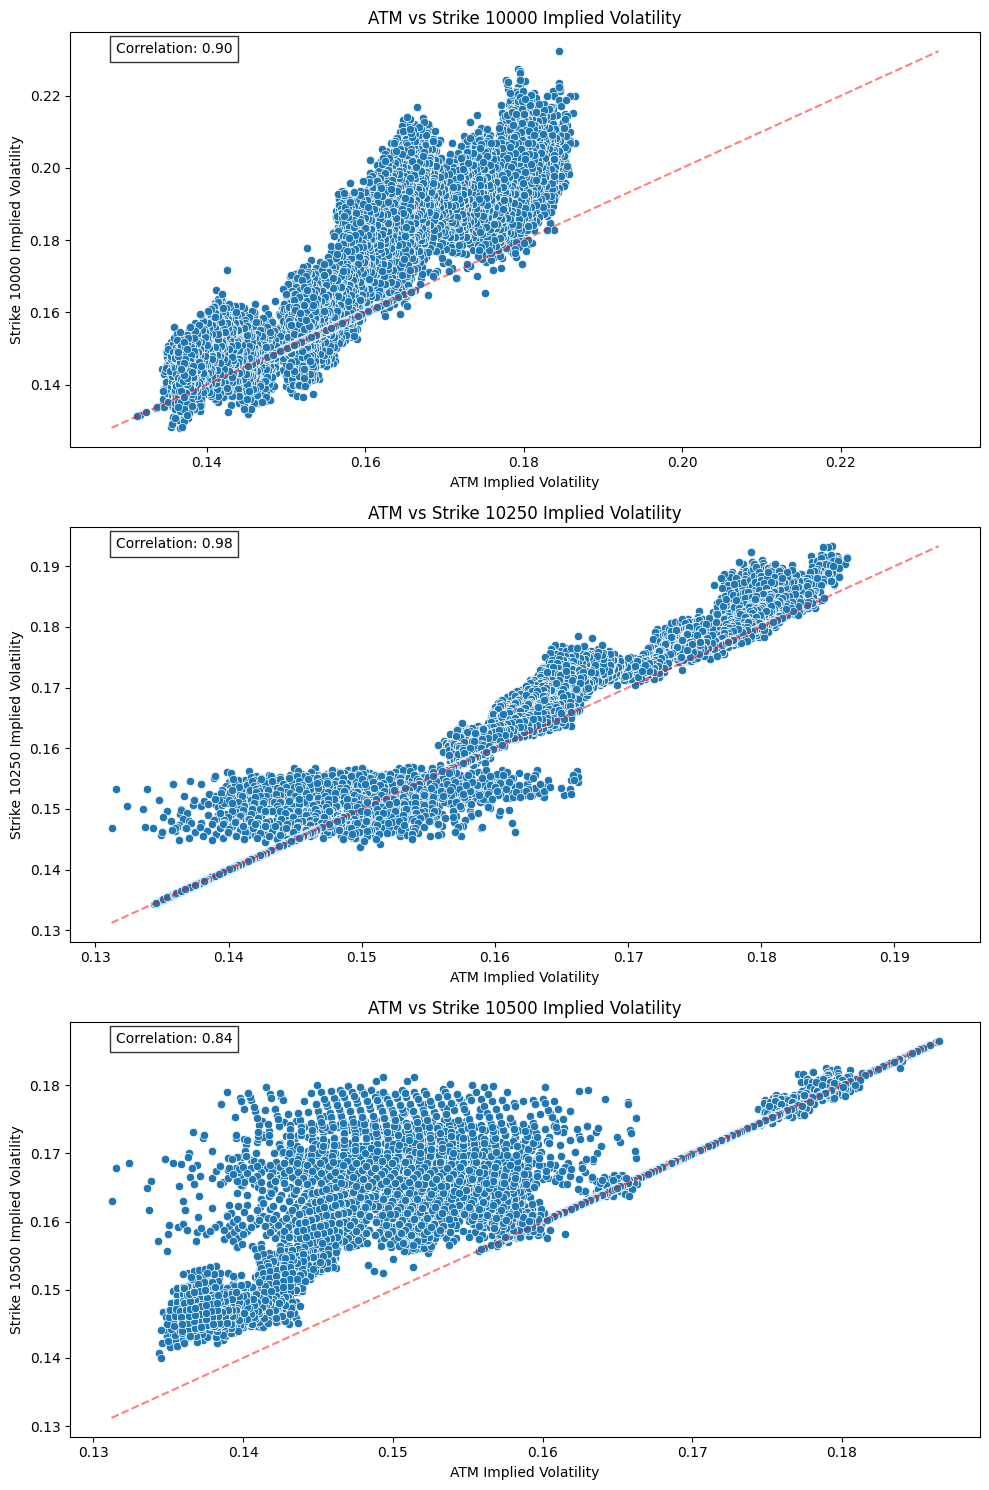

In [16]:
# Get all implied volatility columns
iv_columns = [col for col in df_coconut_call.columns if col.startswith('implied_vol_')]

# Extract strike prices from column names
strikes = [int(col.split('_')[-1]) for col in iv_columns if col not in ['implied_vol_atm']]

# Create a function to find the ATM implied vol for a single row
def find_atm_vol_for_row(row):
    current_spot = row['mid_price_coconut']
    
    # Find the strike closest to current spot
    closest_strike = min(strikes, key=lambda x: abs(x - current_spot))
    
    # Get the column name for the closest strike
    closest_iv_col = f'implied_vol_VOLCANIC_ROCK_VOUCHER_{closest_strike}'
    
    # Return the implied vol for that strike
    return row[closest_iv_col]

# Apply the function row by row
df_coconut_call['implied_vol_atm'] = df_coconut_call.apply(find_atm_vol_for_row, axis=1)

import matplotlib.pyplot as plt
import seaborn as sns

# Get all VOLCANIC_ROCK_VOUCHER implied vol columns
voucher_columns = [col for col in df_coconut_call.columns 
                  if col.startswith('implied_vol_VOLCANIC_ROCK_VOUCHER_')]

# Create subplots
fig, axes = plt.subplots(len(voucher_columns), 1, figsize=(10, 5*len(voucher_columns)))
if len(voucher_columns) == 1:
    axes = [axes]  # Make it iterable if only one subplot

# Plot each strike's implied vol against ATM implied vol
for ax, voucher_col in zip(axes, voucher_columns):
    strike = voucher_col.split('_')[-1]
    
    # Scatter plot
    sns.scatterplot(data=df_coconut_call, 
                   x='implied_vol_atm', 
                   y=voucher_col,
                   ax=ax)
    
    # Add 45-degree line
    min_val = min(df_coconut_call['implied_vol_atm'].min(), 
                 df_coconut_call[voucher_col].min())
    max_val = max(df_coconut_call['implied_vol_atm'].max(), 
                 df_coconut_call[voucher_col].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5)
    
    # Add labels and title
    ax.set_xlabel('ATM Implied Volatility')
    ax.set_ylabel(f'Strike {strike} Implied Volatility')
    ax.set_title(f'ATM vs Strike {strike} Implied Volatility')
    
    # Add correlation coefficient
    corr = df_coconut_call['implied_vol_atm'].corr(df_coconut_call[voucher_col])
    ax.text(0.05, 0.95, f'Correlation: {corr:.2f}', 
            transform=ax.transAxes, 
            bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

implied_vol_VOLCANIC_ROCK_VOUCHER_10000 0.8775166595711652 0.0 17.17817506154053 0.16014407903987254
implied_vol_VOLCANIC_ROCK_VOUCHER_10250 0.24940107008092294 0.0 3.975792272768377 0.16014407903987254
implied_vol_VOLCANIC_ROCK_VOUCHER_10500 1.5585842169404147 0.0 9.807924155724203 0.16014407903987254


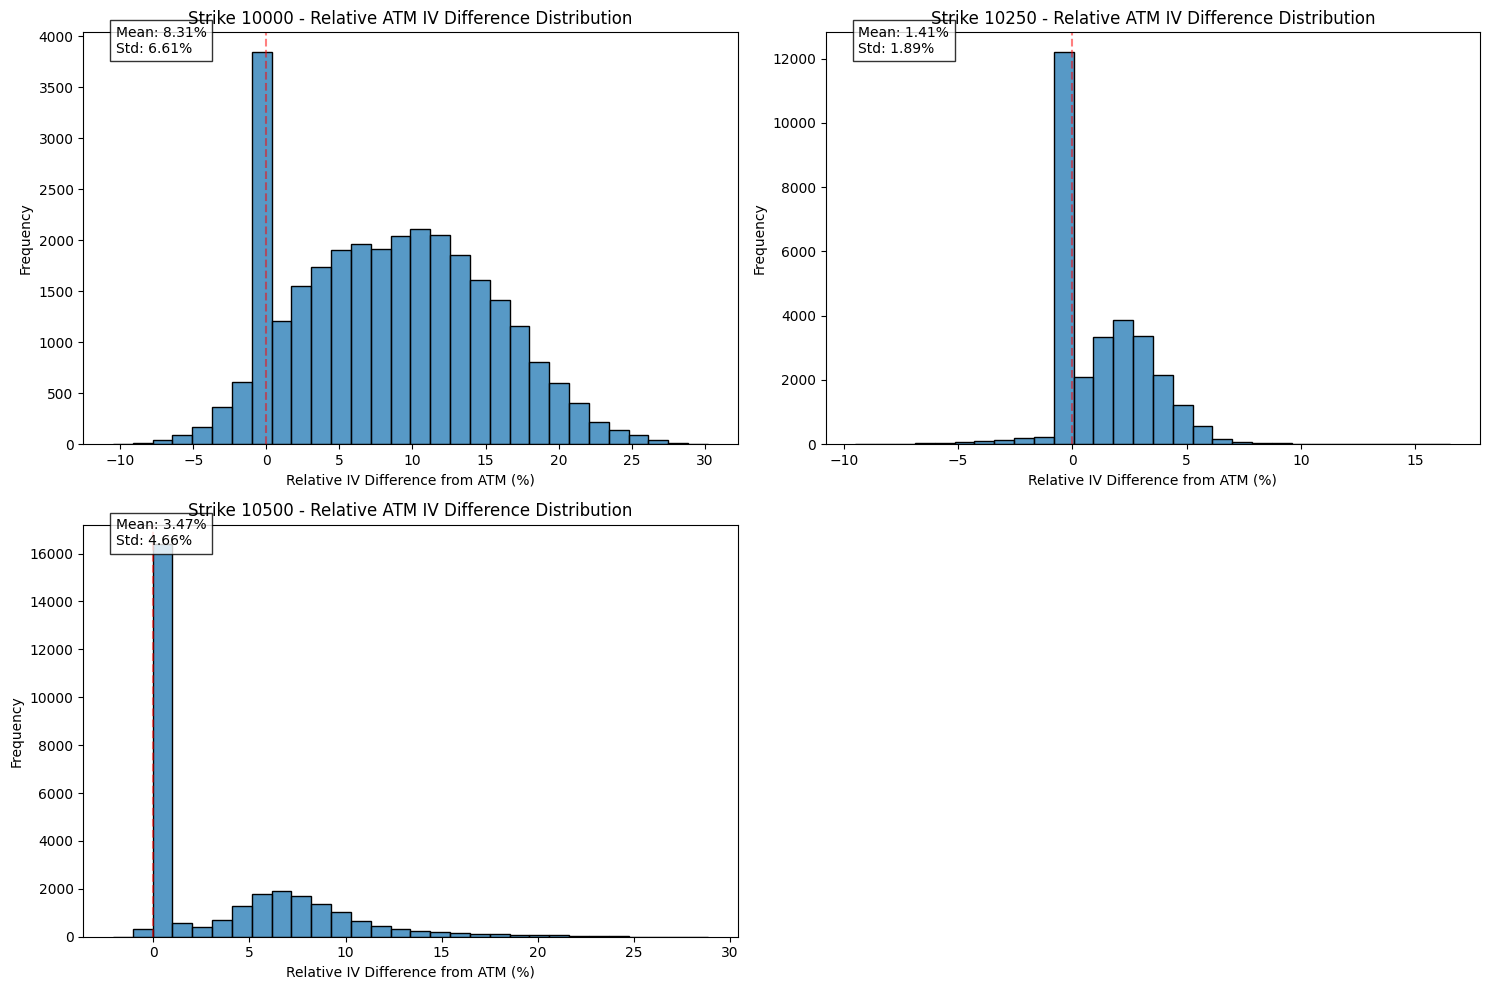

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get all VOLCANIC_ROCK_VOUCHER implied vol columns
voucher_columns = [col for col in df_coconut_call.columns 
                  if col.startswith('implied_vol_VOLCANIC_ROCK_VOUCHER_')]

# Calculate number of rows needed for subplots
n_cols = 2
n_rows = (len(voucher_columns) + 1) // 2

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)  # Make it 2D if only one row

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot histogram for each strike
for ax, voucher_col in zip(axes, voucher_columns):
    strike = voucher_col.split('_')[-1]
    
    # Calculate relative difference (percentage difference)
    relative_diff = (df_coconut_call[voucher_col] - df_coconut_call['implied_vol_atm'].mean()) / df_coconut_call['implied_vol_atm'].mean() * 100
    diff_not_0 = relative_diff[relative_diff != 0]
    print(voucher_col, diff_not_0.quantile(0.1), relative_diff.quantile(0.1), relative_diff.quantile(0.9),df_coconut_call['implied_vol_atm'].mean())
    # Plot histogram
    sns.histplot(data=relative_diff, ax=ax, bins=30)
    
    # Add vertical line at 0
    ax.axvline(x=0, color='r', linestyle='--', alpha=0.5)
    
    # Add statistics
    mean_diff = relative_diff.mean()
    std_diff = relative_diff.std()
    ax.text(0.05, 0.95, 
            f'Mean: {mean_diff:.2f}%\nStd: {std_diff:.2f}%', 
            transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.8))
    
    # Add labels and title
    ax.set_xlabel('Relative IV Difference from ATM (%)')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Strike {strike} - Relative ATM IV Difference Distribution')

# Remove empty subplots if any
for i in range(len(voucher_columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [ ]:
import plotly.express as px

fig = px.line(df_coconut_call, x='timestamp', y='delta', title='Delta over Time')
fig.show()


In [ ]:
fig = px.line(df_coconut_call, x='timestamp', y='vega', title='Vega over Time')
fig.show()

In [ ]:
fig = px.line(df_coconut_call, x='timestamp', y='implied_vol', title='Implied Volatility over Time')
fig.show()


# backtest strat-trading implied volatility to mean

In [50]:
day = 1

In [51]:
df = get_df(day)

In [53]:
strike_price = 10000  
time_to_expiry = 1
initial_guess = 16

df_coconut = get_product(df, 'COCONUT')
df_coconut_call = get_product(df, "COCONUT_COUPON")
df_coconut_call = df_coconut_call.merge(df_coconut[['timestamp', 'mid_price']], on='timestamp', suffixes=('', '_coconut'))

df_coconut_call['implied_vol'] = df_coconut_call.apply(lambda row: implied_volatility(row['mid_price'], row['mid_price_coconut'], strike_price, time_to_expiry), axis=1)
df_coconut_call['delta'] = df_coconut_call.apply(lambda row: delta(row['mid_price_coconut'], strike_price, time_to_expiry, row['implied_vol']), axis=1)
df_coconut_call['gamma'] = df_coconut_call.apply(lambda row: gamma(row['mid_price_coconut'], strike_price, time_to_expiry, row['implied_vol']), axis=1)
df_coconut_call['vega'] = df_coconut_call.apply(lambda row: vega(row['mid_price_coconut'], strike_price, time_to_expiry, row['implied_vol']), axis=1)

In [54]:
df_backtest = df_coconut_call[['timestamp', 'mid_price', 'mid_price_coconut', 'implied_vol', 'delta', 'vega']]
df_backtest = df_backtest.rename(columns={'mid_price': 'mid_price_coupon'})

In [55]:
df_backtest['implied_vol'].mean()

0.15929416861933776

In [56]:
implied_vol_mean = 0.16

In [59]:
import pandas as pd

# Set the threshold values
upper_threshold = 0.006  # Threshold for selling option
lower_threshold = -0.006  # Threshold for buying option
close_threshold = 0.0001  # Threshold for clearing position

# Initialize variables
position = 0
pnl = 0
vega_pnl = 0
trade_history = []

# Iterate over each row in the dataframe
for idx, row in df_backtest.iterrows():
    implied_vol = row['implied_vol']
    if idx == 0:
        continue
    prev_implied_vol = df_backtest.iloc[idx-1]['implied_vol']
    mid_price_coupon = row['mid_price_coupon']
    mid_price_coconut = row['mid_price_coconut']
    vega = row['vega']
    d = row['delta']

    # Check if implied vol is above the upper threshold and no current position
    if implied_vol > implied_vol_mean + upper_threshold and position == 0:
        # Sell 1 delta hedged option
        position = -1
        entry_price_coupon = mid_price_coupon
        entry_price_coconut = mid_price_coconut
        trade_history.append((-1, entry_price_coupon, entry_price_coconut, implied_vol))

    # Check if implied vol is below the lower threshold and no current position
    elif implied_vol < implied_vol_mean + lower_threshold and position == 0:
        # Buy 1 delta hedged option
        position = 1
        entry_price_coupon = mid_price_coupon
        entry_price_coconut = mid_price_coconut
        trade_history.append((1, entry_price_coupon, entry_price_coconut, implied_vol))

    # Check if implied vol is within the close threshold and there is a current position
    elif abs(implied_vol - implied_vol_mean) <= close_threshold and position != 0:
        # Clear the position
        pnl += position * (mid_price_coupon - entry_price_coupon + d * (entry_price_coconut - mid_price_coconut))
        position = 0
        trade_history.append((0, mid_price_coupon, mid_price_coconut, implied_vol))

    if position != 0:
        vega_pnl += position * vega * (implied_vol - prev_implied_vol) * 100
# Calculate final PnL if there is still an open position
if position != 0:
    pnl += position * (mid_price_coupon - entry_price_coupon + d * (entry_price_coconut - mid_price_coconut))

# Print the trade history and final PnL
print("Trade History:")
for trade in trade_history:
    print(f"Position: {trade[0]}, Option Price: {trade[1]}, Underlying Price: {trade[2]}, Implied Volatility: {trade[3]}")

print(f"\nFinal PnL: {pnl}")

Trade History:
Position: 1, Option Price: 586.5, Underlying Price: 9948.0, Implied Volatility: 0.15399524752672736
Position: 0, Option Price: 613.5, Underlying Price: 9954.5, Implied Volatility: 0.15995343437950454
Position: 1, Option Price: 598.5, Underlying Price: 9973.5, Implied Volatility: 0.15367467401239673
Position: 0, Option Price: 618.5, Underlying Price: 9963.5, Implied Volatility: 0.16003033333350636
Position: -1, Option Price: 638.5, Underlying Price: 9956.0, Implied Volatility: 0.16606009972495858
Position: 0, Option Price: 661.5, Underlying Price: 10044.0, Implied Volatility: 0.1600576652344406
Position: -1, Option Price: 676.5, Underlying Price: 10026.5, Implied Volatility: 0.16620222541361077
Position: 0, Option Price: 667.5, Underlying Price: 10055.0, Implied Volatility: 0.16006128368927394
Position: 1, Option Price: 646.5, Underlying Price: 10061.0, Implied Volatility: 0.15397101500535001
Position: 0, Option Price: 663.5, Underlying Price: 10047.5, Implied Volatility:

In [62]:
vega_pnl * 600

87004.73740732671

In [38]:
import pandas as pd

# Set the threshold values
upper_threshold = 0.005  # Threshold for selling option
lower_threshold = -0.005  # Threshold for buying option

# Initialize variables
position = 0
pnl = 0
trade_history = []

# Iterate over each row in the dataframe
for _, row in df_backtest.iterrows():
    implied_vol = row['implied_vol']
    mid_price_coupon = row['mid_price_coupon']
    mid_price_coconut = row['mid_price_coconut']
    d = row['delta']

    # Check if implied vol is above the upper threshold
    if implied_vol > implied_vol_mean + upper_threshold:
        # Sell to target position of -1
        if position > -1:
            quantity = -1 - position
            position = -1
            entry_price_coupon = mid_price_coupon
            entry_price_coconut = mid_price_coconut
            trade_history.append((quantity, entry_price_coupon, entry_price_coconut, implied_vol))

    # Check if implied vol is below the lower threshold
    elif implied_vol < implied_vol_mean + lower_threshold:
        # Buy to target position of 1
        if position < 1:
            quantity = 1 - position
            position = 1
            entry_price_coupon = mid_price_coupon
            entry_price_coconut = mid_price_coconut
            trade_history.append((quantity, entry_price_coupon, entry_price_coconut, implied_vol))

# Calculate final PnL for the remaining position
if position != 0:
    pnl += position * (mid_price_coupon - entry_price_coupon + d * (entry_price_coconut - mid_price_coconut))

# Print the trade history and final PnL
print("Trade History:")
for trade in trade_history:
    print(f"Quantity: {trade[0]}, Option Price: {trade[1]}, Underlying Price: {trade[2]}, Implied Volatility: {trade[3]}")

print(f"\nFinal PnL: {pnl}")

Trade History:
Quantity: 1, Option Price: 588.5, Underlying Price: 9944.5, Implied Volatility: 0.15495607230821157
Quantity: -2, Option Price: 639.0, Underlying Price: 9964.5, Implied Volatility: 0.1650645587541441
Quantity: 2, Option Price: 650.5, Underlying Price: 10062.0, Implied Volatility: 0.154837279111737

Final PnL: -9.25964891012682
